In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

test

In [36]:
bzcat = pd.read_excel('data/bzcat_full.xlsx') # BZCAT provided in Excel
bzcat.drop(['id'], inplace=True, axis=1)
bzcat.head(3)

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Rmag,Class,Flux_density1.4,Flux_density143,X-ray_flux,Fermi_flux
0,5BZQJ0000-3221,00 00 20.39,-32 21 01.0,1.275,18.2,7211,521.0,NaN,0.05,NaN
1,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,18.1,7211,348.0,NaN,NaN,NaN
2,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,21.6,7211,265.0,NaN,NaN,NaN


### Getting the radio-to-optical spectral index from the original Roma-BZCAT dataset

In [37]:
# Getting spectral indices. Here bzcat5.dat is the original BZCAT dataset 
# Suggesting the order of objects are the same in both files!!!
sp_indices = []
with open('data/bzcat5.dat') as f:
    for line in f:
        sp_indices.append(float(line.split()[-1]))
bzcat['Rad_opt_sp_index'] = sp_indices
bzcat

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Rmag,Class,Flux_density1.4,Flux_density143,X-ray_flux,Fermi_flux,Rad_opt_sp_index
0,5BZQJ0000-3221,00 00 20.39,-32 21 01.0,1.275,18.2,7211,521.0,NaN,0.05,NaN,0.707
1,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,18.1,7211,348.0,NaN,NaN,NaN,0.661
2,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,21.6,7211,265.0,NaN,NaN,NaN,0.917
3,5BZBJ0001-0746,00 01 18.0,-07 46 26.68,NaN,17.9,7300,208.0,NaN,0.35,5.000000e-10,0.553
4,5BZBJ0001-0011,00 01 21.48,-00 11 39.91,0.462,19.6,7300,111.0,NaN,NaN,NaN,0.706
...,...,...,...,...,...,...,...,...,...,...,...
3556,5BZQJ2358+1955,23 58 46.08,+19 55 20.31,1.066,17.8,7211,673.0,NaN,0.31,NaN,0.695
3557,5BZQJ2358+3922,23 58 59.86,+39 22 28.3,1.201,19.2,7211,421.0,434.0,0.40,NaN,0.737
3558,5BZBJ2359-3037,23 59 07.91,-30 37 41.41,0.165,15.8,7300,62.0,NaN,40.20,6.000000e-10,0.304
3559,5BZQJ2359+3850,23 59 33.18,+38 50 42.28,2.711,19.1,7211,524.0,NaN,0.51,NaN,0.745


### Merging with BLCat_general (getting the flux density at 4.8 GHz)

In [4]:
# Data downloaded from https://www.sao.ru/blcat/ (Export button)
general = pd.read_csv('data/BLCat_general.csv')
general['Flux_density4.8'] = general[' Flux density 4.8GHz(Jy)'] * 1000  # mJy
# "mutual" source name for bzcat and blcat:
general['Source name'] = general[' Source name '].apply(lambda x: x[1:14])
general.rename(columns={' Redshift ': 'New_Redshift'}, inplace=True)

In [5]:
# "mutual" source name for bzcat and blcat
bzcat['Source name'] = bzcat.apply(lambda x:
    x['RA (J2000.0)'][0:2] + x['RA (J2000.0)'][3:5] + x['RA (J2000.0)'][6:8] \
    + x['Dec (J2000.0)'][0:3] + x['Dec (J2000.0)'][4:6] + x['Dec (J2000.0)'][7:9], 
    axis=1)

In [6]:
bzcat = bzcat.merge(
    general[['Source name', 'Flux_density4.8', 'New_Redshift']],
    #how='left',  # All objects from BZCAT
    how='inner',  # Objects from BZCAT included in BLCat
    on='Source name'
)

In [7]:
# Adding additional redshifts from BLCat where possible

bzcat['Redshift'] = bzcat.apply(lambda x: 
    x['New_Redshift'] if pd.isnull(x['Redshift']) and x['New_Redshift']!=0 
    else x['Redshift'], axis=1)
bzcat.drop('New_Redshift', axis=1, inplace=True)
bzcat

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Rmag,Class,Flux_density1.4,Flux_density143,X-ray_flux,Fermi_flux,Rad_opt_sp_index,Source name,Flux_density4.8
0,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,18.1,7211,348.0,NaN,NaN,NaN,0.661,000105-155106,200.0
1,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,21.6,7211,265.0,NaN,NaN,NaN,0.917,000108+191434,140.0
2,5BZBJ0001-0746,00 01 18.0,-07 46 26.68,NaN,17.9,7300,208.0,NaN,0.35,5.000000e-10,0.553,000118-074626,180.0
3,5BZBJ0001-0011,00 01 21.48,-00 11 39.91,0.462,19.6,7300,111.0,NaN,NaN,NaN,0.706,000121-001139,50.0
4,5BZBJ0002-0024,00 02 57.16,-00 24 47.08,0.523,19.7,7300,178.0,NaN,NaN,NaN,0.757,000257-002447,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719,5BZBJ2357-1718,23 57 29.68,-17 18 05.29,NaN,16.9,7300,44.0,NaN,13.50,NaN,0.343,235729-171805,20.0
1720,5BZQJ2357-1125,23 57 31.19,-11 25 39.21,0.960,18.6,7211,1814.0,NaN,0.36,NaN,0.837,235731-112539,2040.0
1721,5BZQJ2358-1020,23 58 10.87,-10 20 08.59,1.638,18.7,7211,768.0,NaN,NaN,NaN,0.795,235810-102008,1150.0
1722,5BZQJ2358+0430,23 58 28.85,+04 30 24.8,2.298,19.1,7211,246.0,NaN,NaN,NaN,0.708,235828+043024,140.0


### Merging with the BLCat spectral indices

In [10]:
# Data downloaded from https://www.sao.ru/blcat/ (Export button)
blcat_sp_indices = pd.read_csv('data/BLCat_SpIndices.csv', skiprows=1, 
                               skipfooter=30411, engine='python')

blcat_sp_indices['Source name'] = blcat_sp_indices['name '] \
    .apply(lambda x: x[1:14])  # "mutual" source name
blcat_sp_indices.rename(columns={
    ' alpha(1.1-2.3)GHz ': 'alpha_1.1-2.3',
    ' alpha(2.3-4.8)GHz ': 'alpha_2.3-4.8',
    ' alpha(4.8-7.7)GHz ': 'alpha_4.8-7.7',
    ' alpha(4.8-11.2)GHz ': 'alpha_4.8-11.2',
    ' alpha(7.7-11.2)GHz ': 'alpha_7.7-11.2',
    ' alpha(11.2-21.7)GHz ': 'alpha_11.2-21.7',
    ' alpha(7.7-21.7)GHz ': 'alpha_7.7-21.7'},
    inplace=True
)
blcat_sp_indices.drop(['name '], axis=1, inplace=True)
blcat_sp_indices.replace(' undefined ', np.NaN, inplace=True)  # replace with NaNs
blcat_sp_indices.replace(' undefined', np.NaN, inplace=True)
col_to_float = ['alpha_1.1-2.3', 'alpha_2.3-4.8', 'alpha_4.8-7.7', 'alpha_4.8-11.2',
                'alpha_7.7-11.2', 'alpha_11.2-21.7', 'alpha_7.7-21.7']  # to float
blcat_sp_indices[col_to_float] = blcat_sp_indices[col_to_float].astype(float)
blcat_sp_indices

,alpha_1.1-2.3,err,alpha_2.3-4.8,err.1,alpha_4.8-7.7,err.2,alpha_4.8-11.2,err.3,alpha_7.7-11.2,err.4,alpha_11.2-21.7,err.5,alpha_7.7-21.7,err.6,Source name
0,NaN,NaN,0.055,0.001,-0.382,0.002,-0.289,0.003,-0.173,0.002,-0.059,0.001,-0.100,0.002,000105-155106
1,-0.276,0.005,-0.031,0.001,-0.166,0.005,-0.238,0.008,-0.329,0.012,-0.056,0.003,-0.155,0.008,000108+191434
2,NaN,NaN,0.163,0.001,-0.186,0.002,-0.577,0.005,-1.072,0.011,-0.141,0.003,-0.478,0.01,000118-074626
3,NaN,NaN,-0.642,0.083,-0.374,0.079,-0.521,0.128,-0.707,0.191,NaN,NaN,NaN,NaN,000121-001139
4,NaN,NaN,NaN,NaN,-0.487,0.044,-0.073,0.009,0.449,0.037,NaN,NaN,NaN,NaN,000257-002447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,NaN,NaN,NaN,NaN,-0.858,0.153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,235729-171805
1757,1.056,0.001,0.081,0.001,-0.546,0.001,-0.516,0.001,-0.479,0.001,-0.648,0.001,-0.587,0.001,235731-112539
1758,NaN,NaN,0.729,0.001,0.129,0.001,-0.157,0.001,-0.517,0.001,-0.184,0.001,-0.304,0.001,235810-102008
1759,NaN,NaN,NaN,NaN,-0.829,0.009,-0.603,0.008,-0.318,0.005,NaN,NaN,NaN,NaN,235828+043024


In [11]:
bzcat = bzcat.merge(blcat_sp_indices, how='left', on='Source name')
bzcat

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Rmag,Class,Flux_density1.4,Flux_density143,X-ray_flux,Fermi_flux,...,alpha_4.8-7.7,err.2,alpha_4.8-11.2,err.3,alpha_7.7-11.2,err.4,alpha_11.2-21.7,err.5,alpha_7.7-21.7,err.6
0,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,18.1,7211,348.0,NaN,NaN,NaN,...,-0.382,0.002,-0.289,0.003,-0.173,0.002,-0.059,0.001,-0.100,0.002
1,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,21.6,7211,265.0,NaN,NaN,NaN,...,-0.166,0.005,-0.238,0.008,-0.329,0.012,-0.056,0.003,-0.155,0.008
2,5BZBJ0001-0746,00 01 18.0,-07 46 26.68,NaN,17.9,7300,208.0,NaN,0.35,5.000000e-10,...,-0.186,0.002,-0.577,0.005,-1.072,0.011,-0.141,0.003,-0.478,0.01
3,5BZBJ0001-0011,00 01 21.48,-00 11 39.91,0.462,19.6,7300,111.0,NaN,NaN,NaN,...,-0.374,0.079,-0.521,0.128,-0.707,0.191,NaN,NaN,NaN,NaN
4,5BZBJ0002-0024,00 02 57.16,-00 24 47.08,0.523,19.7,7300,178.0,NaN,NaN,NaN,...,-0.487,0.044,-0.073,0.009,0.449,0.037,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719,5BZBJ2357-1718,23 57 29.68,-17 18 05.29,NaN,16.9,7300,44.0,NaN,13.50,NaN,...,-0.858,0.153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1720,5BZQJ2357-1125,23 57 31.19,-11 25 39.21,0.960,18.6,7211,1814.0,NaN,0.36,NaN,...,-0.546,0.001,-0.516,0.001,-0.479,0.001,-0.648,0.001,-0.587,0.001
1721,5BZQJ2358-1020,23 58 10.87,-10 20 08.59,1.638,18.7,7211,768.0,NaN,NaN,NaN,...,0.129,0.001,-0.157,0.001,-0.517,0.001,-0.184,0.001,-0.304,0.001
1722,5BZQJ2358+0430,23 58 28.85,+04 30 24.8,2.298,19.1,7211,246.0,NaN,NaN,NaN,...,-0.829,0.009,-0.603,0.008,-0.318,0.005,NaN,NaN,NaN,NaN


### Adding variability data

In [12]:
# Data downloaded from https://www.sao.ru/blcat/ (Export button)
var = pd.read_table('data/BLCat_Variability.txt')
var.rename(columns={'name': 'Source name',
    '21.7': 'var_21.7', '11.2': 'var_11.2', '7.7': 'var_7.7',
    '4.8': 'var_4.8', '2.3': 'var_2.3', '1.1': 'var_1.1'},
    inplace=True)
var.replace('-', np.NaN, inplace=True)
col_to_float = [
    'var_21.7', 'var_11.2', 'var_7.7', 'var_4.8', 'var_2.3', 'var_1.1']
var[col_to_float] = var[col_to_float].astype(float)
var


,Source name,var_21.7,var_11.2,var_7.7,var_4.8,var_2.3,var_1.1
0,000105-155106,0.387,NaN,0.333,0.303,NaN,NaN
1,000108+191434,0.571,0.234,0.626,0.468,0.201,NaN
2,000118-074626,0.273,NaN,0.197,0.075,0.054,NaN
3,000121-001139,NaN,-0.094,0.000,-0.010,NaN,NaN
4,000257-002447,NaN,0.404,0.355,0.579,NaN,NaN
...,...,...,...,...,...,...,...
1756,235729-171805,NaN,NaN,NaN,NaN,NaN,NaN
1757,235731-112539,0.100,0.103,0.995,0.169,NaN,0.414
1758,235810-102008,0.347,0.003,0.246,0.440,NaN,NaN
1759,235828+043024,NaN,NaN,0.242,0.369,NaN,NaN


In [13]:
bzcat = bzcat.merge(var, how='left', on='Source name')
bzcat

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Rmag,Class,Flux_density1.4,Flux_density143,X-ray_flux,Fermi_flux,...,alpha_11.2-21.7,err.5,alpha_7.7-21.7,err.6,var_21.7,var_11.2,var_7.7,var_4.8,var_2.3,var_1.1
0,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,18.1,7211,348.0,NaN,NaN,NaN,...,-0.059,0.001,-0.100,0.002,0.387,NaN,0.333,0.303,NaN,NaN
1,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,21.6,7211,265.0,NaN,NaN,NaN,...,-0.056,0.003,-0.155,0.008,0.571,0.234,0.626,0.468,0.201,NaN
2,5BZBJ0001-0746,00 01 18.0,-07 46 26.68,NaN,17.9,7300,208.0,NaN,0.35,5.000000e-10,...,-0.141,0.003,-0.478,0.01,0.273,NaN,0.197,0.075,0.054,NaN
3,5BZBJ0001-0011,00 01 21.48,-00 11 39.91,0.462,19.6,7300,111.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.094,0.000,-0.010,NaN,NaN
4,5BZBJ0002-0024,00 02 57.16,-00 24 47.08,0.523,19.7,7300,178.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.404,0.355,0.579,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719,5BZBJ2357-1718,23 57 29.68,-17 18 05.29,NaN,16.9,7300,44.0,NaN,13.50,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1720,5BZQJ2357-1125,23 57 31.19,-11 25 39.21,0.960,18.6,7211,1814.0,NaN,0.36,NaN,...,-0.648,0.001,-0.587,0.001,0.100,0.103,0.995,0.169,NaN,0.414
1721,5BZQJ2358-1020,23 58 10.87,-10 20 08.59,1.638,18.7,7211,768.0,NaN,NaN,NaN,...,-0.184,0.001,-0.304,0.001,0.347,0.003,0.246,0.440,NaN,NaN
1722,5BZQJ2358+0430,23 58 28.85,+04 30 24.8,2.298,19.1,7211,246.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.242,0.369,NaN,NaN


### Adding SDSS data

In [14]:
# Data scraped from the SDSS file via ./scraper_sdss.ipynb
sdss = pd.read_excel('data/SDSS_data.xlsx', dtype={'SDSS id': 'object'})

# Taking only the SDSS ugriz photometry and extinction from here. 
# Other features will be taken further from the original catalogs
sdss = sdss[['Source name', 'u', 'u_err', 'g', 'g_err', 'r', 'r_err', 'i',
             'i_err', 'z', 'z_err', 'extinction_r']]
sdss.rename(columns={'Source name': 'BZCAT5 Source name'}, inplace=True)
bzcat = bzcat.merge(sdss, how='left', on='BZCAT5 Source name')
bzcat

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Rmag,Class,Flux_density1.4,Flux_density143,X-ray_flux,Fermi_flux,...,u_err,g,g_err,r,r_err,i,i_err,z,z_err,extinction_r
0,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,18.1,7211,348.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,21.6,7211,265.0,NaN,NaN,NaN,...,1.810962,22.51613,0.170212,21.55485,0.107136,21.50295,0.166779,20.89288,0.289602,0.09
2,5BZBJ0001-0746,00 01 18.0,-07 46 26.68,NaN,17.9,7300,208.0,NaN,0.35,5.000000e-10,...,0.024499,18.35997,0.007017,17.90004,0.006683,17.51014,0.006608,17.22145,0.013834,0.07
3,5BZBJ0001-0011,00 01 21.48,-00 11 39.91,0.462,19.6,7300,111.0,NaN,NaN,NaN,...,0.061810,20.16613,0.018461,19.62880,0.015920,19.20600,0.015321,18.93583,0.041487,0.08
4,5BZBJ0002-0024,00 02 57.16,-00 24 47.08,0.523,19.7,7300,178.0,NaN,NaN,NaN,...,0.091048,20.53339,0.025797,19.73431,0.019067,19.03291,0.014880,18.65351,0.035221,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719,5BZBJ2357-1718,23 57 29.68,-17 18 05.29,NaN,16.9,7300,44.0,NaN,13.50,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1720,5BZQJ2357-1125,23 57 31.19,-11 25 39.21,0.960,18.6,7211,1814.0,NaN,0.36,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1721,5BZQJ2358-1020,23 58 10.87,-10 20 08.59,1.638,18.7,7211,768.0,NaN,NaN,NaN,...,0.024492,18.79004,0.009127,18.67775,0.009942,18.42789,0.010689,18.34407,0.033961,0.08
1722,5BZQJ2358+0430,23 58 28.85,+04 30 24.8,2.298,19.1,7211,246.0,NaN,NaN,NaN,...,0.032899,19.02842,0.010156,19.11634,0.014599,19.00159,0.017448,18.80037,0.052143,0.08


### Adding the PanSTARRS data

In [15]:
# Data obtained from the PanSTARRS site via an online request
pstarrs = pd.read_csv('data/PanSTARRS_data.csv')

pstarrs = pstarrs[
    ['objName', '_ra_', '_dec_', 'MatchRA', 'MatchDEC', 'dstArcSec',  
     'gMeanPSFMag', 'gMeanPSFMagErr', 'gMeanPSFMagNpt', 'gMeanPSFMagMin', 'gMeanPSFMagMax', #'gMeanPSFMagStd',
     'rMeanPSFMag', 'rMeanPSFMagErr', 'rMeanPSFMagNpt', 'rMeanPSFMagMin', 'rMeanPSFMagMax', #'rMeanPSFMagStd',
     'iMeanPSFMag', 'iMeanPSFMagErr', 'iMeanPSFMagNpt', 'iMeanPSFMagMin', 'iMeanPSFMagMax', #'iMeanPSFMagStd',
     'zMeanPSFMag', 'zMeanPSFMagErr', 'zMeanPSFMagNpt', 'zMeanPSFMagMin', 'zMeanPSFMagMax', #'zMeanPSFMagStd',
     'yMeanPSFMag', 'yMeanPSFMagErr', 'yMeanPSFMagNpt', 'yMeanPSFMagMin', 'yMeanPSFMagMax', #'yMeanPSFMagStd',
     ]
]

# Dropping duplicates
print(pstarrs.duplicated().mean())
pstarrs.drop_duplicates(inplace=True)
print(pstarrs.duplicated().mean())

0.003933566433566434
0.0


In [16]:
# Choosing the objects with the minimum distance from the source 
# in the cases with multiple identifications
pstarrs.sort_values(['_ra_', '_dec_', 'dstArcSec'], inplace=True)
pstarrs.drop_duplicates(subset=['_ra_', '_dec_'], inplace=True)

# Replacing default unknown values (-999.0) with NaNs) 
pstarrs.replace(-999.0, np.NaN, inplace=True)

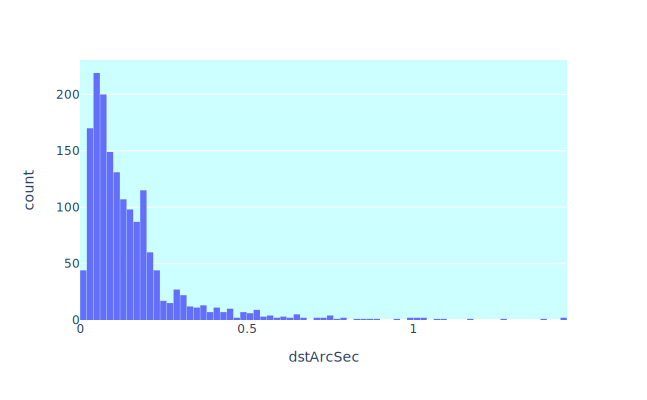

In [17]:
# Offsets histohram

fig = px.histogram(
    pstarrs, x='dstArcSec',
    width=647,
    height=400)
fig.layout.bargap = 0.05
fig.update_layout(plot_bgcolor='#CCFFFF')
fig.show('svg')

In [18]:
# Calculating RA, Dec in degrees to match the sources

def ra_to_deg(x):
    hms = x.split()
    return (int(hms[0])+(int(hms[1])+float(hms[2])/60)/60) * 15
    
    
def del_to_deg(x):
    dms = x.split()
    if dms[0][0] == '-':
        return int(dms[0]) - (int(dms[1])+float(dms[2])/60)/60
    else:
        return int(dms[0]) + (int(dms[1])+float(dms[2])/60)/60


bzcat['ra_deg'] = bzcat['RA (J2000.0)'].apply(ra_to_deg)
bzcat['dec_deg'] = bzcat['Dec (J2000.0)'].apply(del_to_deg)

In [19]:
# Source names based on their coordinates in degrees

bzcat['Source_name_deg'] = bzcat.apply(
    lambda x: '{:07.3f}'.format(x['ra_deg']) 
    + '{:+07.3f}'.format(x['dec_deg']), axis=1
)

pstarrs['Source_name_deg'] = pstarrs.apply(
    lambda x: '{:07.3f}'.format(x['_ra_']) 
    + '{:+07.3f}'.format(x['_dec_']), axis=1
)

In [20]:
# Adding data to the dataset
pstarrs.drop(['objName', '_ra_', '_dec_', 'MatchRA', 'MatchDEC'],
             axis=1, inplace=True)
pstarrs.rename(columns={'dstArcSec': 'PSTARRS_offset'}, inplace=True)
bzcat = bzcat.merge(pstarrs, how='left', on='Source_name_deg')
bzcat

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Rmag,Class,Flux_density1.4,Flux_density143,X-ray_flux,Fermi_flux,...,zMeanPSFMag,zMeanPSFMagErr,zMeanPSFMagNpt,zMeanPSFMagMin,zMeanPSFMagMax,yMeanPSFMag,yMeanPSFMagErr,yMeanPSFMagNpt,yMeanPSFMagMin,yMeanPSFMagMax
0,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,18.1,7211,348.0,NaN,NaN,NaN,...,18.062000,0.018994,11.0,17.969299,18.155001,18.281900,0.015957,19.0,18.043301,18.384399
1,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,21.6,7211,265.0,NaN,NaN,NaN,...,20.689400,0.085499,5.0,20.501801,21.077000,20.228800,0.184468,1.0,20.228800,20.228800
2,5BZBJ0001-0746,00 01 18.0,-07 46 26.68,NaN,17.9,7300,208.0,NaN,0.35,5.000000e-10,...,16.806999,0.087539,8.0,16.581200,17.177799,16.791599,0.027028,6.0,16.780600,16.937201
3,5BZBJ0001-0011,00 01 21.48,-00 11 39.91,0.462,19.6,7300,111.0,NaN,NaN,NaN,...,19.001101,0.023569,10.0,18.908199,19.177000,18.789301,0.035931,14.0,18.554899,19.059500
4,5BZBJ0002-0024,00 02 57.16,-00 24 47.08,0.523,19.7,7300,178.0,NaN,NaN,NaN,...,18.876699,0.024522,6.0,18.819300,18.997299,18.628700,0.032557,13.0,18.477400,18.934099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719,5BZBJ2357-1718,23 57 29.68,-17 18 05.29,NaN,16.9,7300,44.0,NaN,13.50,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1720,5BZQJ2357-1125,23 57 31.19,-11 25 39.21,0.960,18.6,7211,1814.0,NaN,0.36,NaN,...,18.004700,0.032206,4.0,17.962099,18.093100,17.809601,0.033135,8.0,17.750900,18.087200
1721,5BZQJ2358-1020,23 58 10.87,-10 20 08.59,1.638,18.7,7211,768.0,NaN,NaN,NaN,...,18.404600,0.054437,11.0,18.020000,18.786800,18.275101,0.056390,11.0,18.014000,18.918600
1722,5BZQJ2358+0430,23 58 28.85,+04 30 24.8,2.298,19.1,7211,246.0,NaN,NaN,NaN,...,19.026899,0.020428,10.0,18.928801,19.163200,18.804001,0.042747,7.0,18.751499,18.996099


### Adding the GALEX data

In [21]:
# Data scraped from the MAST database via ./scraper_galex.ipynb (astroquery.mast)
galex = pd.read_excel('data/GALEX_data.xlsx')
galex.replace('--', np.NaN, inplace=True)
galex.head(3)

,Unnamed: 0,BZCAT5 Source name,GALEX_offset,fuv_mag,fuv_magerr,nuv_mag,nuv_magerr,fuv_flux,fuv_fluxerr,nuv_flux,nuv_fluxerr,e_bv
0,0,5BZQJ0001-1551,0.164426,NaN,NaN,20.242603,0.047276,NaN,NaN,29.037420,1.264067,0.028843
1,1,5BZBJ0001-0746,0.642668,19.750713,0.153794,19.134195,0.076715,45.679030,6.468830,80.597534,5.693396,0.031354
2,2,5BZBJ0001-0011,0.801958,21.759552,0.086964,21.216990,0.062643,7.180943,0.575032,11.835973,0.682731,0.033941


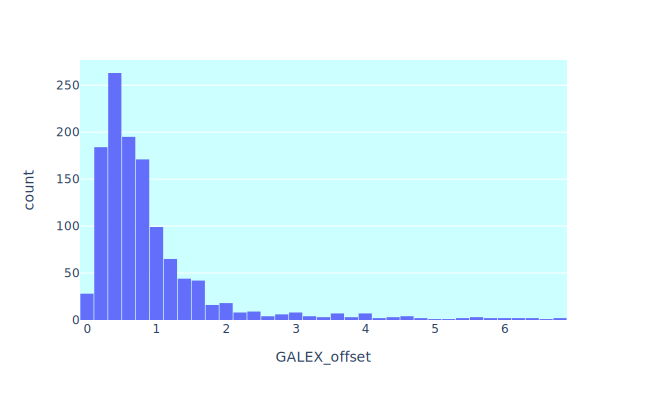

In [22]:
# Offsets histohram

fig = px.histogram(
    galex, x='GALEX_offset',
    width=647,
    height=400)
fig.layout.bargap = 0.05
fig.update_layout(plot_bgcolor='#CCFFFF')
fig.show('svg')

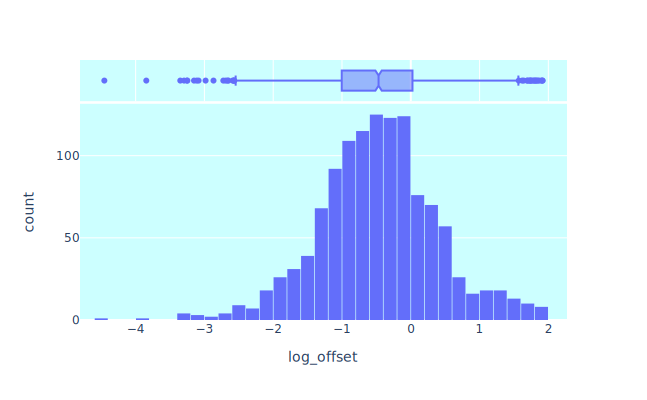

In [23]:
# Logarithmic histogram

galex['log_offset'] = np.log(galex['GALEX_offset'])
fig = px.histogram(
    galex, x='log_offset',
    width=647,
    height=400,
    marginal='box')
fig.layout.bargap = 0.05
fig.update_layout(plot_bgcolor='#CCFFFF')
fig.show('svg')

In [24]:
# Dropping identifications with offsets >= 5 arcseconds

print(galex.shape[0])
mask = galex['GALEX_offset'] < 5
galex = galex[mask]
print(galex.shape[0])

1213
1195


In [25]:
# Adding GALEX data to the dataset

galex.drop(['Unnamed: 0', 'log_offset'], axis=1, inplace=True)
bzcat = bzcat.merge(galex, how='left', on='BZCAT5 Source name')
bzcat

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Rmag,Class,Flux_density1.4,Flux_density143,X-ray_flux,Fermi_flux,...,GALEX_offset,fuv_mag,fuv_magerr,nuv_mag,nuv_magerr,fuv_flux,fuv_fluxerr,nuv_flux,nuv_fluxerr,e_bv
0,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,18.1,7211,348.0,NaN,NaN,NaN,...,0.164426,NaN,NaN,20.242603,0.047276,NaN,NaN,29.037420,1.264067,0.028843
1,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,21.6,7211,265.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5BZBJ0001-0746,00 01 18.0,-07 46 26.68,NaN,17.9,7300,208.0,NaN,0.35,5.000000e-10,...,0.642668,19.750713,0.153794,19.134195,0.076715,45.679030,6.468830,80.597534,5.693396,0.031354
3,5BZBJ0001-0011,00 01 21.48,-00 11 39.91,0.462,19.6,7300,111.0,NaN,NaN,NaN,...,0.801958,21.759552,0.086964,21.216990,0.062643,7.180943,0.575032,11.835973,0.682731,0.033941
4,5BZBJ0002-0024,00 02 57.16,-00 24 47.08,0.523,19.7,7300,178.0,NaN,NaN,NaN,...,0.385246,22.944971,0.210739,21.921448,0.116782,2.409981,0.467658,6.186154,0.665223,0.035323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719,5BZBJ2357-1718,23 57 29.68,-17 18 05.29,NaN,16.9,7300,44.0,NaN,13.50,NaN,...,4.557269,19.170790,0.093875,18.645855,0.046287,77.926650,6.736080,126.373863,5.386276,0.024232
1720,5BZQJ2357-1125,23 57 31.19,-11 25 39.21,0.960,18.6,7211,1814.0,NaN,0.36,NaN,...,0.162729,NaN,NaN,19.338163,0.088990,NaN,NaN,66.793520,5.473237,0.031471
1721,5BZQJ2358-1020,23 58 10.87,-10 20 08.59,1.638,18.7,7211,768.0,NaN,NaN,NaN,...,0.585816,NaN,NaN,20.637546,0.018781,NaN,NaN,20.182776,0.349041,0.035123
1722,5BZQJ2358+0430,23 58 28.85,+04 30 24.8,2.298,19.1,7211,246.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Adding the WISE and 2MASS data

In [26]:
# Data scraped the WISE database via ./scraper_wise.ipynb
wise = pd.read_excel('data/WISE_data.xlsx')
wise.head(3)

,Unnamed: 0,Source,w1,w1_err,w2,w2_err,w3,w3_err,w4,w4_err,J,J_err,H,H_err,K,K_err,offset_arcs
0,0,5BZQJ0001-1551,15.120000,0.036,13.938,0.040,10.511,0.090,8.371,0.383,NaN,NaN,NaN,NaN,NaN,NaN,0.233935
1,1,5BZQJ0001+1914,16.287001,0.072,15.260,0.100,11.796,NaN,9.053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.353622
2,2,5BZBJ0001-0746,12.702000,0.024,11.752,0.023,9.163,0.036,6.975,0.111,16.132999,0.081,15.269,0.082,14.491,0.087,0.331406


In [27]:
#Converting non-detections to NaN.  Non-detections are those where w_err = NaN

def no_detections(x):
    if np.isnan(x['w1_err']):
        x['w1'] = np.NaN
    if np.isnan(x['w2_err']):
        x['w2'] = np.NaN
    if np.isnan(x['w3_err']):
        x['w3'] = np.NaN
    if np.isnan(x['w4_err']):
        x['w4'] = np.NaN
    return x    


wise = wise.apply(no_detections, axis=1)
wise.head(3)

,Unnamed: 0,Source,w1,w1_err,w2,w2_err,w3,w3_err,w4,w4_err,J,J_err,H,H_err,K,K_err,offset_arcs
0,0,5BZQJ0001-1551,15.120000,0.036,13.938,0.040,10.511,0.090,8.371,0.383,NaN,NaN,NaN,NaN,NaN,NaN,0.233935
1,1,5BZQJ0001+1914,16.287001,0.072,15.260,0.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.353622
2,2,5BZBJ0001-0746,12.702000,0.024,11.752,0.023,9.163,0.036,6.975,0.111,16.132999,0.081,15.269,0.082,14.491,0.087,0.331406


Looking for the maximum possible offset for cross-identification between the BZCAT and WISE coordinates. WISE angular resolution is about 6 arcseconds. The scraping was made by a "cone search" method with a radius parameter 0.0025 deg, which is about 9 arcseconds (it looked like the minimum possible to find the objects)

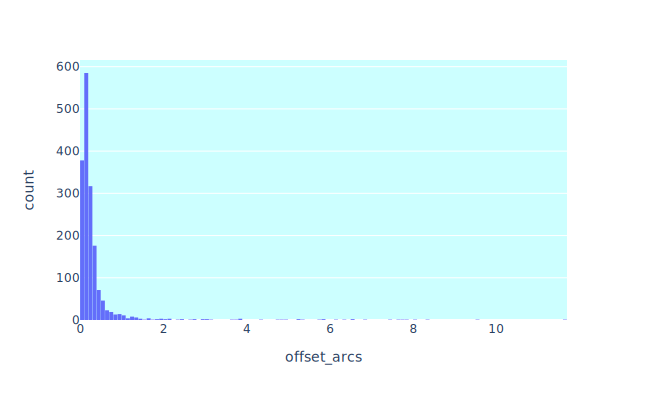

In [28]:
# Offsets histohram

fig = px.histogram(
    wise, x='offset_arcs',
    width=647,
    height=400)
fig.layout.bargap = 0.05
fig.update_layout(plot_bgcolor='#CCFFFF')
fig.show('svg')

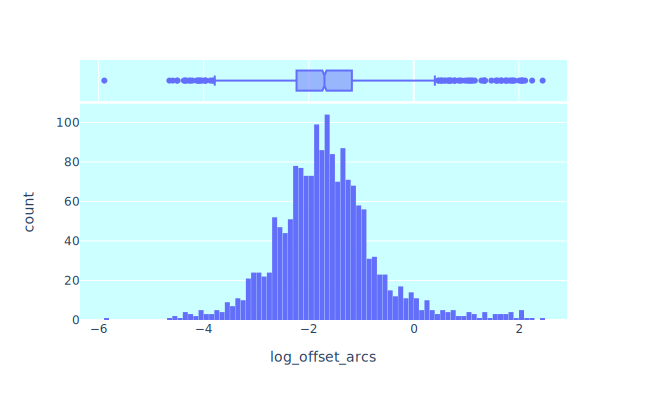

In [29]:
# Logarithmic histogram

wise['log_offset_arcs'] = np.log(wise['offset_arcs'])
fig = px.histogram(
    wise, x='log_offset_arcs',
    width=647,
    height=400,
    marginal='box')
fig.layout.bargap = 0.05
fig.update_layout(plot_bgcolor='#CCFFFF')
fig.show('svg')

We will take the maximum possible offset as the upper fence = 0.4 in the log scale, or 1.5 arcseconds

In [30]:
# Dropping identifications with offsets >= 1.5 arcseconds

print(wise.shape[0])
mask = wise['offset_arcs'] < 1.5
wise = wise[mask]
print(wise.shape[0])

1745
1674


In [31]:
# Adding WISE data to the dataset

wise.drop(['Unnamed: 0', 'log_offset_arcs'], axis=1, inplace=True)
wise.rename(columns={'Source': 'BZCAT5 Source name', 'offset_arcs': 'WISE_offset'}, 
            inplace=True)
bzcat = bzcat.merge(wise, how='left', on='BZCAT5 Source name')
bzcat

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Rmag,Class,Flux_density1.4,Flux_density143,X-ray_flux,Fermi_flux,...,w3_err,w4,w4_err,J,J_err,H,H_err,K,K_err,WISE_offset
0,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,18.1,7211,348.0,NaN,NaN,NaN,...,0.090,8.371,0.383,NaN,NaN,NaN,NaN,NaN,NaN,0.233935
1,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,21.6,7211,265.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.353622
2,5BZBJ0001-0746,00 01 18.0,-07 46 26.68,NaN,17.9,7300,208.0,NaN,0.35,5.000000e-10,...,0.036,6.975,0.111,16.132999,0.081,15.269,0.082,14.491,0.087,0.331406
3,5BZBJ0001-0011,00 01 21.48,-00 11 39.91,0.462,19.6,7300,111.0,NaN,NaN,NaN,...,0.374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.360386
4,5BZBJ0002-0024,00 02 57.16,-00 24 47.08,0.523,19.7,7300,178.0,NaN,NaN,NaN,...,0.162,NaN,NaN,16.993999,0.171,15.970,0.194,15.523,0.228,0.310923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719,5BZBJ2357-1718,23 57 29.68,-17 18 05.29,NaN,16.9,7300,44.0,NaN,13.50,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1720,5BZQJ2357-1125,23 57 31.19,-11 25 39.21,0.960,18.6,7211,1814.0,NaN,0.36,NaN,...,0.058,7.130,0.121,16.419001,0.110,16.296,0.174,15.170,0.151,0.031356
1721,5BZQJ2358-1020,23 58 10.87,-10 20 08.59,1.638,18.7,7211,768.0,NaN,NaN,NaN,...,0.064,7.587,0.163,NaN,NaN,NaN,NaN,NaN,NaN,0.227173
1722,5BZQJ2358+0430,23 58 28.85,+04 30 24.8,2.298,19.1,7211,246.0,NaN,NaN,NaN,...,0.275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.023486


### Adding the NED data on extinction

In [32]:
extinct = pd.read_excel('data/NED_extinction.xlsx')
extinct.drop(['Unnamed: 0', 'RA (J2000.0)', 'Dec (J2000.0)'], axis=1, inplace=True)
bzcat = bzcat.merge(extinct, how='left', on='BZCAT5 Source name')
bzcat

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Rmag,Class,Flux_density1.4,Flux_density143,X-ray_flux,Fermi_flux,...,ext_SDSS_u,ext_SDSS_g,ext_SDSS_r,ext_SDSS_i,ext_SDSS_z,ext_PS1_g,ext_PS1_r,ext_PS1_i,ext_PS1_z,ext_PS1_y
0,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,18.1,7211,348.0,NaN,NaN,NaN,...,0.123,0.096,0.066,0.049,0.037,0.092,0.066,0.049,0.038,0.031
1,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,21.6,7211,265.0,NaN,NaN,NaN,...,0.176,0.137,0.095,0.070,0.052,0.132,0.094,0.070,0.055,0.045
2,5BZBJ0001-0746,00 01 18.0,-07 46 26.68,NaN,17.9,7300,208.0,NaN,0.35,5.000000e-10,...,0.134,0.105,0.072,0.054,0.040,0.101,0.072,0.053,0.042,0.034
3,5BZBJ0001-0011,00 01 21.48,-00 11 39.91,0.462,19.6,7300,111.0,NaN,NaN,NaN,...,0.144,0.112,0.078,0.058,0.043,0.108,0.077,0.057,0.045,0.037
4,5BZBJ0002-0024,00 02 57.16,-00 24 47.08,0.523,19.7,7300,178.0,NaN,NaN,NaN,...,0.150,0.117,0.081,0.060,0.045,0.113,0.081,0.060,0.047,0.039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719,5BZBJ2357-1718,23 57 29.68,-17 18 05.29,NaN,16.9,7300,44.0,NaN,13.50,NaN,...,0.103,0.080,0.055,0.041,0.031,0.077,0.055,0.041,0.032,0.026
1720,5BZQJ2357-1125,23 57 31.19,-11 25 39.21,0.960,18.6,7211,1814.0,NaN,0.36,NaN,...,0.133,0.104,0.072,0.053,0.040,0.100,0.071,0.053,0.042,0.034
1721,5BZQJ2358-1020,23 58 10.87,-10 20 08.59,1.638,18.7,7211,768.0,NaN,NaN,NaN,...,0.150,0.117,0.081,0.060,0.045,0.112,0.080,0.059,0.047,0.038
1722,5BZQJ2358+0430,23 58 28.85,+04 30 24.8,2.298,19.1,7211,246.0,NaN,NaN,NaN,...,0.146,0.113,0.079,0.058,0.043,0.109,0.078,0.058,0.045,0.037


### Adding the FIRST data

In [33]:
source_name = []
peak_flux = []
integrated_flux = []
noise = []
with open('data/FIRST.txt') as f:
    for line in f:
        split_line = line.split()
        if len(split_line)==32:  # not header or footer
            source_name.append(
                split_line[5] + split_line[6] + split_line[7][0:2] \
                    + split_line[8] + split_line[9] + split_line[10][0:2])
            peak_flux.append(float(split_line[12]))
            integrated_flux.append(float(split_line[13]))
            noise.append(float(split_line[14]))

first = pd.DataFrame({
    'Source name': source_name, 'FIRST_peak_flux': peak_flux,
    'FIRST_integrated_flux': integrated_flux, 'FIRST_rms_noise': noise
})
bzcat = bzcat.merge(first, how='left', on='Source name')
bzcat

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Rmag,Class,Flux_density1.4,Flux_density143,X-ray_flux,Fermi_flux,...,ext_SDSS_i,ext_SDSS_z,ext_PS1_g,ext_PS1_r,ext_PS1_i,ext_PS1_z,ext_PS1_y,FIRST_peak_flux,FIRST_integrated_flux,FIRST_rms_noise
0,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,18.1,7211,348.0,NaN,NaN,NaN,...,0.049,0.037,0.092,0.066,0.049,0.038,0.031,NaN,NaN,NaN
1,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,21.6,7211,265.0,NaN,NaN,NaN,...,0.070,0.052,0.132,0.094,0.070,0.055,0.045,NaN,NaN,NaN
2,5BZBJ0001-0746,00 01 18.0,-07 46 26.68,NaN,17.9,7300,208.0,NaN,0.35,5.000000e-10,...,0.054,0.040,0.101,0.072,0.053,0.042,0.034,225.01,235.87,0.278
3,5BZBJ0001-0011,00 01 21.48,-00 11 39.91,0.462,19.6,7300,111.0,NaN,NaN,NaN,...,0.058,0.043,0.108,0.077,0.057,0.045,0.037,NaN,NaN,NaN
4,5BZBJ0002-0024,00 02 57.16,-00 24 47.08,0.523,19.7,7300,178.0,NaN,NaN,NaN,...,0.060,0.045,0.113,0.081,0.060,0.047,0.039,118.89,151.27,0.097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719,5BZBJ2357-1718,23 57 29.68,-17 18 05.29,NaN,16.9,7300,44.0,NaN,13.50,NaN,...,0.041,0.031,0.077,0.055,0.041,0.032,0.026,NaN,NaN,NaN
1720,5BZQJ2357-1125,23 57 31.19,-11 25 39.21,0.960,18.6,7211,1814.0,NaN,0.36,NaN,...,0.053,0.040,0.100,0.071,0.053,0.042,0.034,NaN,NaN,NaN
1721,5BZQJ2358-1020,23 58 10.87,-10 20 08.59,1.638,18.7,7211,768.0,NaN,NaN,NaN,...,0.060,0.045,0.112,0.080,0.059,0.047,0.038,784.60,799.21,0.133
1722,5BZQJ2358+0430,23 58 28.85,+04 30 24.8,2.298,19.1,7211,246.0,NaN,NaN,NaN,...,0.058,0.043,0.109,0.078,0.058,0.045,0.037,265.77,270.16,0.091


In [34]:
bzcat.drop(['Source name', 'Source_name_deg', 'ra_deg', 'dec_deg'], 
           axis=1, inplace=True)
bzcat.to_excel('data/combined_dataset_BLCat.xlsx')